In [1]:
from __future__ import division
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import batman

%matplotlib inline

In [2]:
params = batman.TransitParams()
params.t0 = 0.0                     #transit midpoint time (days)
params.per = 1.4857108              #orbital period (days)
params.rp = 0.14                    #R_planet/R_star
params.a = 5.48                     #a/R_star
params.inc = 87.2                   #orbital inclination (degrees)
params.ecc = 0.0                    #eccentricity
params.w = 90.                      #longitude of periastron (degrees)
params.limb_dark = "nonlinear"      #limb darkening model--other choices include quadratic, etc.
params.u = [0., 0.05, 0.05, 0.05]   #coefficients for a nonlinear limb darkening law.

In [3]:
t = np.linspace(-0.3, 0.3, 1e3)

In [4]:
m = batman.TransitModel(params, t)
flux = m.light_curve(params) 

flux = flux + np.random.normal(loc=0.0, scale=0.005, size=len(flux))


moving_mean = np.convolve(flux, np.ones(21)/21., mode='valid')

print np.min(moving_mean)
print np.max(moving_mean)
print np.shape(moving_mean)

0.977920813863
1.00223526679
(980,)


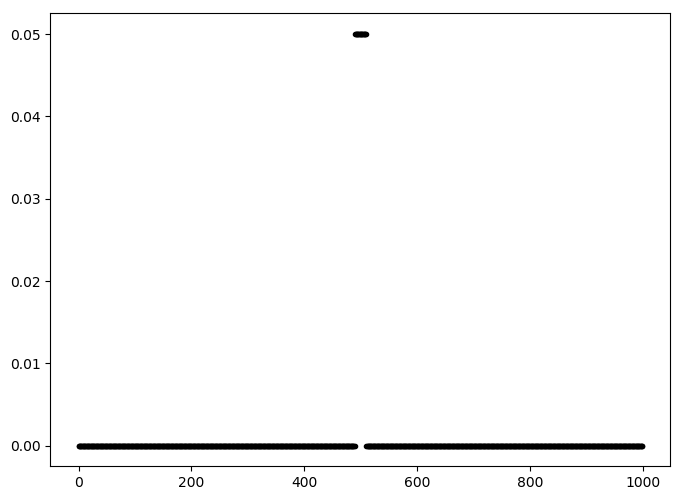

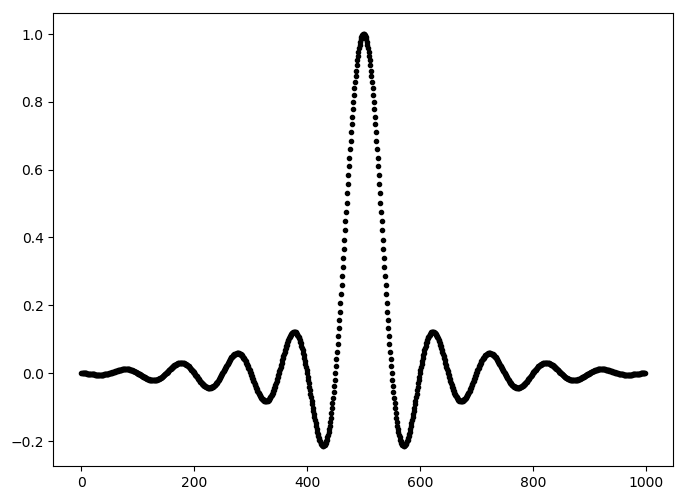

(1000,)
(1000,)


In [5]:
fft_flux = np.fft.fft(flux)

tophat = np.zeros_like(flux)
tophat[490:510] = 1./20.

fig = plt.figure(figsize=(8,6))
plt.plot(tophat,'k.')
plt.show()

fft_tophat = np.fft.fft(tophat)
fft_tophat[1::2] = -1.*fft_tophat[1::2] #If I do this, I don't have to np.fft.ifftshift the convolution below in order to recover the expected moving median signal.
# fft_tophat = -1.*fft_tophat #just experimenting...if I do this, I get back (-(moving median))
fig = plt.figure(figsize=(8,6))
plt.plot(np.fft.fftshift(fft_tophat).real,'k.')
#plt.plot(np.fft.fftshift(fft_flux).real,'r-')
#plt.ylim(-5.,5.)
plt.show()


print np.shape(fft_tophat)
print np.shape(fft_flux)

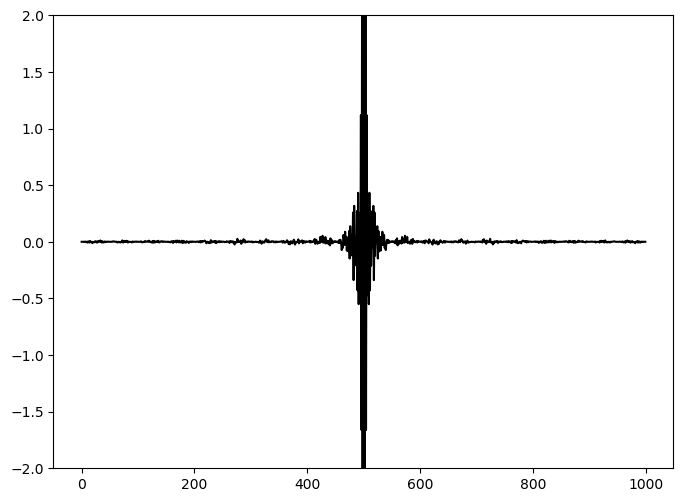

In [7]:
fig = plt.figure(figsize=(8,6))
plt.plot(np.fft.fftshift(fft_tophat * fft_flux).real,'k-')
plt.ylim(-2,2)
plt.show()

In [8]:
ifft_convolution = np.fft.ifft(fft_tophat * fft_flux)
print np.shape(ifft_convolution)

(1000,)


(1000,)


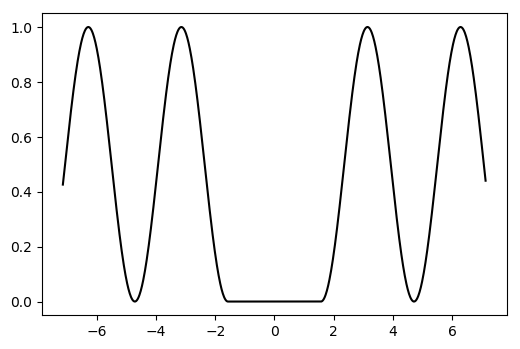

6.06652069748
2.50662827463


In [64]:
#test newly designed filter...
x = np.arange(-500,500)/70.
print np.shape(x)
newFilter = 1.-(np.sin(x)**2)
newFilter[(x > -np.pi/2.) & (x < np.pi/2.)] = 0.

plt.plot(x,newFilter,'k-')
plt.show()

step = x[1]-x[0]
normIntegral = np.sum(newFilter*step)
print normIntegral

print np.sqrt(2.*np.pi)
ifft_newfilter_convolution = np.fft.ifft(newFilter * fft_flux)

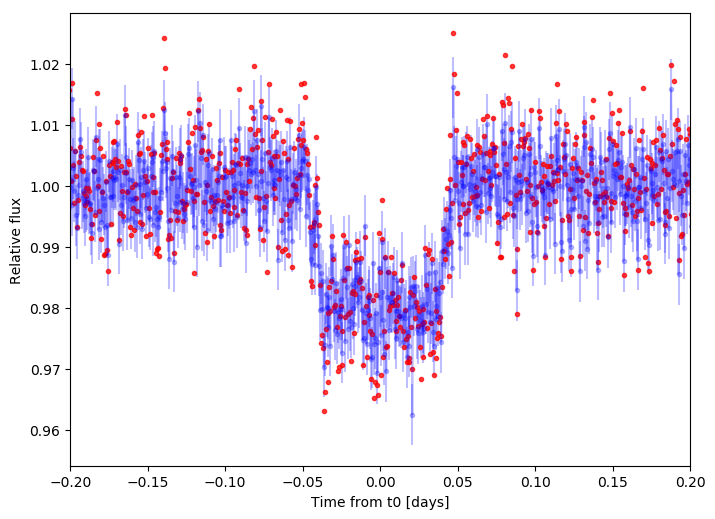

In [71]:
fig = plt.figure(figsize=(8,6))
plt.errorbar(t, flux, yerr=0.005, color='b',marker='.',alpha=0.25)
#moving mean calculated "by hand"
#plt.plot(t[10:-10], moving_mean, 'r-',lw=3)

#moving mean recovered from F^(-1) [fft(tophat) * fft(flux)] works as expected
#plt.plot(t, ifft_convolution + 0.005, 'b-',lw=3)

#what happens with F^(-1) [fft(newFilter) * fft(flux)] ? note needs multiplicative constant to match
plt.plot(t, ifft_newfilter_convolution*2.35, 'r.',lw=2,alpha=0.75)

plt.xlabel("Time from t0 [days]")
plt.ylabel("Relative flux")
plt.xlim(-0.2,0.2)
plt.show()

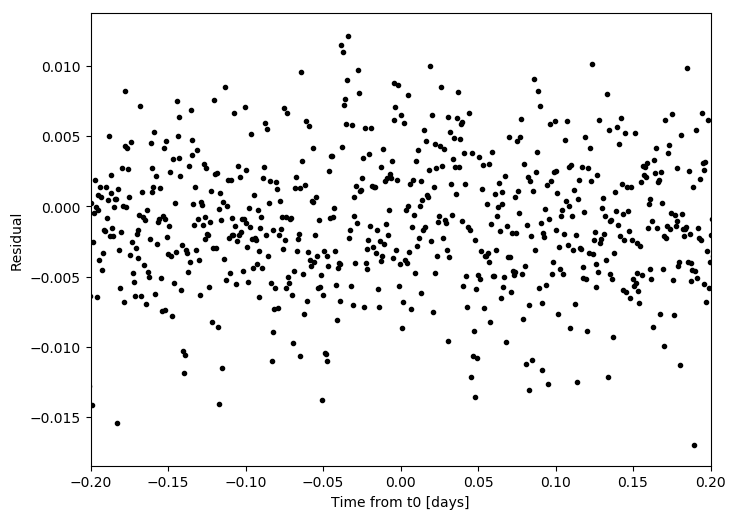

In [72]:
#residuals from new filter?
fig = plt.figure(figsize=(8,6))
plt.plot(t, flux - (ifft_newfilter_convolution*2.35), 'k.')
plt.xlabel("Time from t0 [days]")
plt.ylabel("Residual")
plt.xlim(-0.2,0.2)
plt.show()